# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В распоряжении имеются исторические данные: технические характеристики, комплектации и цены автомобилей. Необходимо посторить модель для определения стоимости автомобиля. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


Предоставленный файл формата CSV cогласно приложенному описанию включает следующие столбцы:

    -DateCrawled — дата скачивания анкеты из базы
    -VehicleType — тип автомобильного кузова
    -RegistrationYear — год регистрации автомобиля
    -Gearbox — тип коробки передач
    -Power — мощность (л. с.)
    -Model — модель автомобиля
    -Kilometer — пробег (км)
    -RegistrationMonth — месяц регистрации автомобиля
    -FuelType — тип топлива
    -Brand — марка автомобиля
    -NotRepaired — была машина в ремонте или нет
    -DateCreated — дата создания анкеты
    -NumberOfPictures — количество фотографий автомобиля
    -PostalCode — почтовый индекс владельца анкеты (пользователя)
    -LastSeen — дата последней активности пользователя
    -Price - цена (евро)

## Подготовка данных

In [1]:
import category_encoders as ce
import lightgbm as lgb
import numpy as np
import pandas as pd
import time
import warnings

from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import make_scorer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.utils import shuffle

C:\Users\lebeda\anaconda3\envs\praktikum_env_win_new\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
%matplotlib inline

In [3]:
warnings.simplefilter('ignore')

### Чтение и первичный анализ данных

Для изучения предоставленных данных получим первые 5 строк таблицы, изучим общую информацию о таблице, получим данные о количестве пропусков, полных дубликатов. Выведем описательные статистики значений, содержащихся в файле, списки и количество уникальных значений столбцов.

In [4]:
df = pd.read_csv(r'C:\Users\lebeda\Yandex_Practicum\Yandex_projects\data_sets\prjkt_11(sp14)\autos.csv') #чтение предоставленного файла

In [5]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [7]:
df.shape

(354369, 16)

In [8]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [9]:
df.duplicated().sum()

4

In [10]:
df.describe(include = 'all')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
count,354369,354369.000000,316879,354369.000000,334536,354369.000000,334664,354369.000000,354369.000000,321474,354369,283215,354369,354369.0,354369.000000,354369
unique,271174,NaN,8,NaN,2,NaN,250,NaN,NaN,7,40,2,109,NaN,NaN,179150
top,2016-03-24 14:49:47,NaN,sedan,NaN,manual,NaN,golf,NaN,NaN,petrol,volkswagen,no,2016-04-03 00:00:00,NaN,NaN,2016-04-06 13:45:54
freq,7,NaN,91457,NaN,268251,NaN,29232,NaN,NaN,216352,77013,247161,13719,NaN,NaN,17
mean,NaN,4416.656776,NaN,2004.234448,NaN,110.094337,NaN,128211.172535,5.714645,NaN,NaN,NaN,NaN,0.0,50508.689087,NaN
std,NaN,4514.158514,NaN,90.227958,NaN,189.850405,NaN,37905.341530,3.726421,NaN,NaN,NaN,NaN,0.0,25783.096248,NaN
min,NaN,0.000000,NaN,1000.000000,NaN,0.000000,NaN,5000.000000,0.000000,NaN,NaN,NaN,NaN,0.0,1067.000000,NaN
25%,NaN,1050.000000,NaN,1999.000000,NaN,69.000000,NaN,125000.000000,3.000000,NaN,NaN,NaN,NaN,0.0,30165.000000,NaN
50%,NaN,2700.000000,NaN,2003.000000,NaN,105.000000,NaN,150000.000000,6.000000,NaN,NaN,NaN,NaN,0.0,49413.000000,NaN
75%,NaN,6400.000000,NaN,2008.000000,NaN,143.000000,NaN,150000.000000,9.000000,NaN,NaN,NaN,NaN,0.0,71083.000000,NaN


In [11]:
for column in df.columns:
     print(column, df[column].nunique(), df[column].unique())


DateCrawled 271174 ['2016-03-24 11:52:17' '2016-03-24 10:58:45' '2016-03-14 12:52:21' ...
 '2016-03-21 09:50:58' '2016-03-14 17:48:27' '2016-03-19 18:57:12']
Price 3731 [  480 18300  9800 ... 12395 18429 10985]
VehicleType 8 [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other']
RegistrationYear 151 [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 99

DateCreated 109 ['2016-03-24 00:00:00' '2016-03-14 00:00:00' '2016-03-17 00:00:00'
 '2016-03-31 00:00:00' '2016-04-04 00:00:00' '2016-04-01 00:00:00'
 '2016-03-21 00:00:00' '2016-03-26 00:00:00' '2016-04-07 00:00:00'
 '2016-03-15 00:00:00' '2016-03-11 00:00:00' '2016-03-20 00:00:00'
 '2016-03-23 00:00:00' '2016-03-27 00:00:00' '2016-03-12 00:00:00'
 '2016-03-13 00:00:00' '2016-03-18 00:00:00' '2016-03-10 00:00:00'
 '2016-03-07 00:00:00' '2016-03-09 00:00:00' '2016-03-08 00:00:00'
 '2016-04-03 00:00:00' '2016-03-29 00:00:00' '2016-03-25 00:00:00'
 '2016-03-28 00:00:00' '2016-03-30 00:00:00' '2016-03-22 00:00:00'
 '2016-02-09 00:00:00' '2016-03-05 00:00:00' '2016-04-02 00:00:00'
 '2016-03-16 00:00:00' '2016-03-19 00:00:00' '2016-04-05 00:00:00'
 '2016-03-06 00:00:00' '2016-02-12 00:00:00' '2016-03-03 00:00:00'
 '2016-03-01 00:00:00' '2016-03-04 00:00:00' '2016-04-06 00:00:00'
 '2016-02-15 00:00:00' '2016-02-24 00:00:00' '2016-02-27 00:00:00'
 '2015-03-20 00:00:00' '2016-02-28 00:00:00' '

**Первичный анализ данных выявил следующие аномалии и артефакты:**

 - В 5 из 16 столбцов ('VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired') присутсвуют пропуски значений в значимом количестве (не менее 19705 из 354369 строк, то есть не менее 5,56 %).
 
 
 - В таблице присутствует 4 строки, которые являются полными дубликатами.
 
 
 - В столбце 'Price' минимальные значения уровня цен определены в 0 евро - такое часто встречается в реальных объявлениях, если продавец не определился с ценой, однако для целей прогонозирования цены такое авто не подходит.
 
 
 - В стобце 'RegistrationYear' присутствуют аномальные значения года регистрации автомобиля как по нижней границе условно допустимого диапазона (например, 1900 год), так и по верхней (последний год выгрузки объявлений 2016 год). Вероятно, это связано с ошибками записи или занесения информации в карточку обявления.
 
 
 - В стобце 'RegistrationMonth	' - месяц регистрации присутсвуют значния 0, что не соответсвует нормальному диапазону данных (1-12).
 
 
 - В столбце 'Power' (мощность в лошадиных силах) присутсвуют сверхмалые значения (0) и сверхбольшие значения (более 500). 
  
  
 Наличие нулевых значений мощности могло быть вызвано ошибкой занесения данных или их отсутсвием.
  
  Сверхбольшие значения мощности - это, вероятно, ошибки занесения данных, так как на текуший момент мощности суперкаров лежат в пределах от 500 до 1600 л.с., при этом их стоимость далеко не ограничивается приведенным максимальным значением цены в 20000 евро.
  
  
 - Cтолбец 'NumberOfPictures' (количество фотографий автомобиля) не содержит никаких других значений - кроме нуля. Столбец неинформативен. По сути данные в нем отсутсвуют.

### Подготовка данных

**_Удаление полных дубликатов строк._**

In [12]:
df.drop_duplicates(inplace=True)
df= df.reset_index(drop=True)

**_Удаление строк с нулевым значением цены ('Price')._**

Так как цена является целевым признаком при построении прогноза, заполнение пропусков в соответвующем столбце средними или иными значениями неуместно. 

array([[<AxesSubplot:title={'center':'Price'}>]], dtype=object)

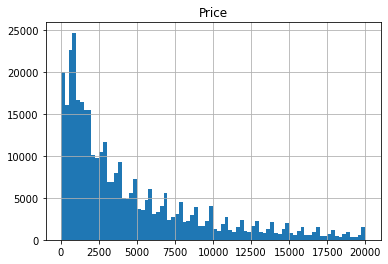

In [13]:
df.hist('Price', bins=(80)) #гистограмма для уровня разброса цен

<AxesSubplot:>

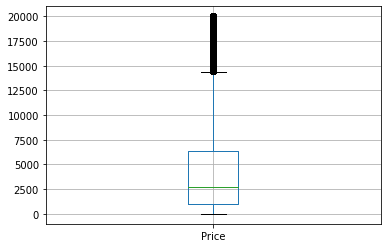

In [14]:
df.boxplot('Price') #'ящик с усами' для уровня цен

In [15]:
df.query('Price == 0')['Price'].count() #количество строк с нулевым значением цен

10772

In [16]:
df.query('Price < 100')['Price'].count() #количество строк со значением цен менее 100 евро

13314

In [17]:
df.query('Price < 500')['Price'].count() #количество строк с нулевым значением цен менее 500 евро

36054

В качестве критерия недостоверности цен определим стоимость автомобиля менее 100 евро. Количество строк с ценами менее 100 евро составляет около 3,7% от общего объема информации, удалим такие строки.

In [18]:
df = df.query('Price >= 100').reset_index(drop=True) #удаление строк со значениями цен ниже 100 евро

**_Удаление строк с аномальным значением года регистрации автомобиля ('RegistrationYear')._**

Чтобы избежать ошибок в процессе прогонозирования удалим строки с аномальными значениями годов выпуска авто (раньше сроков начала промышленного производства и позже года последней даты выгрузки, так как на момент выгрузки год регистрации автомобиля не может превышать года выгрузки объявления).

In [19]:
#последний ("старший") год выгрузки данных
pd.DatetimeIndex(df.DateCrawled).year.max()

2016

In [20]:
df.RegistrationYear.max() #последний, старейший год регистрации

9999

In [21]:
#количество записей со сроком регистрации превышающем дату последнего года выгрузки
df.query('RegistrationYear > 2016')['RegistrationYear'].count() 

13687

In [22]:
#колличество строк с аномальным значением года регистрации автомобиля
df.query('RegistrationYear < 1900 or RegistrationYear > 2016')['RegistrationYear'].count() 

13730

In [23]:
#удаление строк с аномальным годом регистрации автомобиля
df = df.query('RegistrationYear >= 1900 or RegistrationYear <= 2016').reset_index(drop=True)

**_Заполнение пропусков в столбце модели автомобиля ('Model')_**

Восстановить наименование модели автомобиля на основании прочих данных достаточно сложно, однако пропусков в этом столбце весомое колличество (более 19000) и удалять их некорректро. Заполним пропуски в столбце модели автомобиля значением 'other', которое уже используется в таблице.

In [24]:
df.query('Model == "other"').Model.count()

23499

In [25]:
df.query('Model == "other"').head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
23,2016-03-13 20:40:49,500,sedan,1990,manual,118,other,150000,10,petrol,mercedes_benz,yes,2016-03-13 00:00:00,0,35390,2016-03-13 20:40:49
37,2016-04-01 17:45:07,11900,other,2002,manual,129,other,150000,11,gasoline,volkswagen,no,2016-04-01 00:00:00,0,10551,2016-04-05 12:47:30
38,2016-03-25 15:50:30,1500,bus,1984,manual,70,other,150000,8,gasoline,mercedes_benz,no,2016-03-25 00:00:00,0,22767,2016-03-27 03:17:02
50,2016-04-04 10:57:36,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,2016-04-04 00:00:00,0,34454,2016-04-06 12:45:43
55,2016-03-10 20:53:19,2399,NaN,2018,manual,64,other,125000,3,NaN,seat,no,2016-03-10 00:00:00,0,33397,2016-03-25 10:17:37
64,2016-03-21 12:47:55,2100,suv,2000,manual,105,other,150000,8,petrol,honda,no,2016-02-09 00:00:00,0,85244,2016-03-31 16:46:09
65,2016-03-15 09:51:05,1280,sedan,1992,auto,109,other,150000,9,petrol,mercedes_benz,NaN,2016-03-15 00:00:00,0,86163,2016-04-05 19:18:21
83,2016-03-13 19:52:34,1800,bus,2001,manual,87,other,150000,7,gasoline,mitsubishi,no,2016-03-13 00:00:00,0,24116,2016-03-17 13:47:41
87,2016-04-02 23:25:25,1222,sedan,1984,auto,180,other,150000,3,petrol,opel,NaN,2016-04-02 00:00:00,0,57290,2016-04-06 14:44:57
109,2016-04-04 09:50:15,3500,coupe,1991,manual,160,other,150000,5,petrol,volkswagen,no,2016-04-04 00:00:00,0,66111,2016-04-06 11:17:02


Как видно из выше представленных данных наименование модели "other" не является каким-либо уникальным (в том числе именем собственным), позволяющим однозначно идентифицировать конкретню модель конкретной марки определенного вида кузова. Оно в том числе используется ввиду отсутствия данных.

In [26]:
df.Model = df.Model.fillna('other')

**_Заполнение пропусков в столбце тип коробки передач ('Gearbox')_**

В столбце типа коробки предач присутствует только два уникальных значения: автоматическая коробка передач и механическая. Поскольку данный признак - это важный элемент определения стоимости автомобиля, то пропуски в этом столбце невозможно заполнить каким-то конкретным значением ввиду разнонобразия комлектаций моделей авто (для любой модели могут быть характерны оба вида коробок передач). Заполним пропуски значением 'undefined_gbt' (неустановленный тип КПП - undefined gearbox type)

In [27]:
df.Gearbox = df.Gearbox.fillna('undefined_gbt')

**_Заполнение пропусков в столбце тип топлива ('FuelType')_**

Аналогично предыдущему пункту поступим с пропусками в столбце типа топлива. Так как одна и та же модель может иметь комлектации на разном виде топлива, и этот параметр также влияет на цену авто, заполним пропуски значением 'undefined_ft' (undefined_fuel_type - неустановленный тип топлива)

In [28]:
df.FuelType = df.FuelType.fillna('undefined_ft')

**_Заполнение пропусков в столбце тип кузова ('VehicleType')_**

Одна и та же модель автомобиля может быть выпущена в разных кузовах (например, седан, универсал, хетчбек); кроме того, при заполнеии типа кузова в существующей таблице могут быть допущены ошибки (например, в таблице присутсвует строка, в которой автомобиль компакт-класса Nissan Micra отнесен к классу автобусов). Таким образом, заполнение пропусков на основании модели автомобиля также нецелесообразно. Заполним пропуски в столбце типа кузова значением 'other', которое уже используется в таблице.

In [29]:
df.VehicleType = df.VehicleType.fillna('other')

**_Заполнение пропусков в столбце информации о ремонте автомобиля ('NotRepaired')_**

В отсутсвии какой-либо информации о наличии факта ремонта автомобиля заполним пропуски в столбце информации о ремонте автомобиля значением 'no_information' ("нет информации").

In [30]:
df.NotRepaired = df.NotRepaired.fillna('no_information')

**_Замена нулевых значений месяца регистации автомобиля на значение 1._**

В случае, если месяцем регистации автомобиля указано значение 0, будем интерпритировать такое значение как отсутсвие конкретных данных по месяцу, а за месяц регисрации будем применять значение 1 - начало года регистрации.

In [31]:
df.query('RegistrationMonth == 0')['RegistrationMonth'].count() #колличество строк с месяцем регистрации автомобиля 0

31633

In [32]:
#замена месяца регистрации автомобиля со значением 0 на значение 1
df.loc[(df.RegistrationMonth == 0), 'RegistrationMonth'] = 1

**_Обработка строк с аномальным значением мощности автомобиля._**

Удалим строки с анаомально высокими значениями мощности автомобиля. Автомобили с мощностью более 500 - 600 л.с. относятся к категории супер- и гиперкаров. Учитывая то, что в таблице максимальная стоимость автомобилей не превышает 20000 евро, будем считать, что подобные автомобили в таблице отсутсвуют; авто в таблице с такими значениями мощности - это некорретно занесенные данные.

In [33]:
#количество строк с аномально высоким значением мощности автомомбиля
df.query('Power > 600')['Power'].count() 

353

In [34]:
#удаление строк с аномально высоким значением мощности автомомбиля
df = df.query('Power < 600').reset_index(drop=True)

Также определим количество строк с нулевым значением мощности автомобилей.

In [35]:
#количество строк с нулевыми значениями мощности автомобиля
df.query('Power == 0')['Power'].count()

35062

Использование подобных значений мощности некорретно, так как по сути - это отсутствующие данные. Ввиду того, что диапазон мощности двигателей моторной гаммы одной модели достаточно узок, заменим нулевые значения мощности на усредненное по конкретной модели значение. Данное действие приблизит значения мощностей к адекватному уровню.

In [36]:
#создание словаря средних мощностей моделей автомобилей
model_power_dict = {} 
for i in df.Model.unique().tolist():
    model_power_dict[i] = df.query('Model == @i')['Power'].dropna().mean()
model_power_dict

{'golf': 96.62274638352454,
 'other': 101.95030395887906,
 'grand': 156.79963898916967,
 'fabia': 73.8824101068999,
 '3er': 141.51991185266803,
 '2_reihe': 87.7721145745577,
 'c_max': 114.49337260677467,
 '3_reihe': 100.51264705882353,
 'passat': 121.00020449897751,
 'navara': 144.54444444444445,
 'ka': 52.273151750972765,
 'polo': 58.94062099871959,
 'twingo': 51.61064366848969,
 'a_klasse': 86.3159688412853,
 'scirocco': 148.71039182282794,
 '5er': 181.99894819879043,
 'meriva': 97.54501452081317,
 'arosa': 45.66743648960739,
 'c4': 109.12814645308924,
 'civic': 94.42003105590062,
 'transporter': 96.82733347704247,
 'punto': 58.08980733374767,
 'e_klasse': 162.6491041603401,
 'clio': 64.97495631916132,
 'kadett': 67.50931677018633,
 'kangoo': 62.20384204909285,
 'one': 88.14915254237287,
 'fortwo': 54.61561842412906,
 '1er': 137.6352435530086,
 'b_klasse': 115.22784810126582,
 'signum': 151.28423236514521,
 'astra': 95.54873472529587,
 'a8': 255.5224171539961,
 'jetta': 91.0951008645

На основании полученного словаря проведем замену нулевых значений мощности на среднее значение для конкретной модели, данные приведем к целочисленному типу.

In [37]:
df.Power = df.where(df.Power == 0)['Model'].map(model_power_dict).fillna(df.Power).astype(int)

In [38]:
df.query('Power==0') #проверка наличия записей с нулевым значением мощности

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
225164,2016-03-30 11:39:08,3800,wagon,1978,manual,0,serie_1,30000,1,gasoline,land_rover,no_information,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08


In [39]:
df.query('Model=="serie_1"')

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
225164,2016-03-30 11:39:08,3800,wagon,1978,manual,0,serie_1,30000,1,gasoline,land_rover,no_information,2016-03-30 00:00:00,0,49824,2016-03-30 11:39:08


Как видно, в одной из записей замены не произошло вледствие наличия единственной записи по указанной модели автомобиля, удалим эту строку.

In [40]:
df = df.drop(index=[225164]).reset_index(drop=True)

In [41]:
df.isna().sum() #количество пропусков по столбцам после обработки

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340688 entries, 0 to 340687
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        340688 non-null  object
 1   Price              340688 non-null  int64 
 2   VehicleType        340688 non-null  object
 3   RegistrationYear   340688 non-null  int64 
 4   Gearbox            340688 non-null  object
 5   Power              340688 non-null  int32 
 6   Model              340688 non-null  object
 7   Kilometer          340688 non-null  int64 
 8   RegistrationMonth  340688 non-null  int64 
 9   FuelType           340688 non-null  object
 10  Brand              340688 non-null  object
 11  NotRepaired        340688 non-null  object
 12  DateCreated        340688 non-null  object
 13  NumberOfPictures   340688 non-null  int64 
 14  PostalCode         340688 non-null  int64 
 15  LastSeen           340688 non-null  object
dtypes: int32(1), int64(6

Пропуски и артефакты обработаны. Потеря данных несущественна и составила 13681 строк или примерно 3.86 %.

### Подготовка таблицы признаков и целевого признака для обучающей модели, получение обущающих, валидационных и тестовых выборок.

**Подотовка целевого признака**

В качестве целевого признака согласно цели проекта обозначем цену автомобиля 'Price'.

In [43]:
target = df.Price

**Подотовка таблицы признаков**

Для целей прогнозирования стоимости автомобиля не иммеют значения параметры публикации и использования самого объявления, такие как время публикации ('DateCreated'), время последнего просмотра ('LastSeen'), дата скачивания анкеты из базы ('DateCrawled'), количество фотографий ('NumberOfPictures'), невысокую ценность в определении стоимости должен играть и почтовый индекс владельца ('PostalCode'). Все остальные призаки должны использоваться для определения предполагаемой цены автомобиля.

In [44]:
features = df.drop(columns=['Price', 'DateCreated', 'LastSeen', 'DateCrawled','NumberOfPictures', 'PostalCode'], axis=0)
features.head()

,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,other,1993,manual,96,golf,150000,1,petrol,volkswagen,no_information
1,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no_information
3,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [45]:
features.shape

(340688, 10)

In [46]:
target.shape

(340688,)

Часть из представленных признаков относится к категориальному типу, далее для задачи регрессии преобразуем категориальные признаки в числовые, однако для различных моделей обучения будем использовать различные техники кодирования (порядковое или прямое) в сочетании со стандартизацией признаков.

### Вывод

Прпредоставленный файл - таблица из 354639 строк и 16 столбцов. Каждая строка содержит информацию с описанием представленного на продажу автомобиля (цена, марка, модель, тип кузова, мощность двигателя, тип топлива, пробег, информация о ремонте, тип КПП, почтовый код владельца, колчество фотографий), а также информацию об операциях с объявлением (время создания, время последнего просмотра, время выгрузки из базы данных). 

Согласно приложенному описанию таблица включает следующие столбцы:

    -DateCrawled — дата скачивания анкеты из базы
    -VehicleType — тип автомобильного кузова
    -RegistrationYear — год регистрации автомобиля
    -Gearbox — тип коробки передач
    -Power — мощность (л. с.)
    -Model — модель автомобиля
    -Kilometer — пробег (км)
    -RegistrationMonth — месяц регистрации автомобиля
    -FuelType — тип топлива
    -Brand — марка автомобиля
    -NotRepaired — информация о ремонте
    -DateCreated — дата создания анкеты
    -NumberOfPictures — количество фотографий автомобиля
    -PostalCode — почтовый индекс владельца анкеты (пользователя)
    -LastSeen — дата последней активности пользователя
    -Price - цена (евро)

В ходе поготовкки данных проведены следующие операции:


 - В 5 из 16 столбцов ('VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired') обнаружены пропуски значений - произведена замена пропусков на значения, обозначающие отсутствие информации по данным признакам.
 
 
 - Обнаружены 4 строки, которые являются полными дубликатами - строки удалены.
 
 
 - В столбце 'Price' для строк с ценой автомобиля менее 100 евро данные удалены.
 
 
 - В столбце 'RegistrationYear' обнаружены аномальные значения года регистрации автомобиля - строки, включаюшие сроки регистрации раньше 1900 года и позже 2016 года, удалены.
 
 
 - В стобце 'RegistrationMonth	 месяц регистрации обнаружены значения 0 - заменены на 1.
 
 
 - В столбце 'Power' (мощность в лошадиных силах) обнаружены сверхмалые значения (0 л.с.) - заменены на среднее значение мощности для модели; сверхбольшие значения (более 600 л.с.) - строки удалены.
 
  

- Произведенно выделение целевого признака (target) - столбец 'Price' (цена)- и признаков (features) для моделей обучения ('VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model','Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode'), включающие только характеристики автомобиля и индекс владельца.

## Обучение моделей

Для обучения и валидации моделей с учетом их специфических возможностей создадим функцию получения необходимых выборок.

In [47]:
def sample_trn_tst_val(features, target):
    features_train, features_test_valid, target_train, target_test_valid = train_test_split(features, target, 
                                                                                            test_size=0.4, 
                                                                                            random_state = 12345)
    features_test, features_valid, target_test, target_valid = train_test_split(features_test_valid, 
                                                                                        target_test_valid, 
                                                                                        test_size=0.5, 
                                                                                        random_state = 12345)
    
    return features_train, target_train, features_valid, target_valid, features_test, target_test

Для предсказаний стоимости автомобиля реализуем и оценим качество следующих моделей: линейная регрессия, решающее дерево, случайный лес, градиентный бустинг.

### Модель линейной регрессии

Для модели линейной регресии преобразуем категориальные признаки в численные техникой прямого кодирования (OHE), как наиболее оптимальной для задач линейной регресии, с удалением первых столбцов полученных фиктивных признаков для оптимизации процесса обучения и исключения "дамми-ловушки".

In [48]:
features_lr = pd.get_dummies(features, columns=['VehicleType', 'Gearbox', 'FuelType', 'Brand', 'NotRepaired'], drop_first=True)

In [49]:
encoder= ce.BinaryEncoder(cols=['Model'],return_df=True)
features_lr=encoder.fit_transform(features_lr) 
features_lr.head()

,RegistrationYear,Power,Model_0,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_no_information,NotRepaired_yes
0,1993,96,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,2011,190,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,1
2,2004,163,0,0,0,0,0,0,1,1,...,0,0,0,0,0,0,0,0,1,0
3,2001,75,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
4,2008,69,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [50]:
features_lr.shape

(340688, 69)

In [51]:
features_train_lr, target_train_lr, features_valid_lr, target_valid_lr, features_test_lr, target_test_lr = sample_trn_tst_val(features_lr, target)

In [52]:
features_train_lr.shape

(204412, 69)

In [53]:
target_train_lr.shape

(204412,)

In [54]:
features_valid_lr.shape

(68138, 69)

In [55]:
target_valid_lr.shape

(68138,)

In [56]:
features_test_lr.shape

(68138, 69)

In [57]:
target_test_lr.shape

(68138,)

Проведем масштабирование признаков для модели линейной регресии.

In [58]:
scaler = StandardScaler()
scaler.fit(features_train_lr) 

features_train_scaled_lr = scaler.transform(features_train_lr)
features_test_scaled_lr = scaler.transform(features_test_lr)
features_valid_scaled_lr = scaler.transform(features_valid_lr)

pd.options.mode.chained_assignment = None

Обучим модель линейной регрессии.

In [59]:
 # подготовка и обучение модели линейной регресии
model_lr = LinearRegression().fit(features_train_scaled_lr, target_train_lr)

predicted_valid_lr = model_lr.predict(features_valid_scaled_lr)
rmse_predict_lr = mean_squared_error(target_valid_lr, predicted_valid_lr, squared=False)

In [60]:
rmse_predict_lr

2980.0532386951822

### Модели решающего дерева и случайного леса

Для моделей решаюшего дерева и случайго леса преобразуем категориальные признаки в численные техникой порядкового кодирования (OE), как наиболее оптимальной для обучения "деревянных" моделей.

In [61]:
encoder = OrdinalEncoder()
features_wm = pd.DataFrame(encoder.fit_transform(features), columns=features.columns)

In [62]:
features_wm.shape

(340688, 10)

In [63]:
features_train_wm, target_train_wm, features_valid_wm, target_valid_wm, features_test_wm, target_test_wm = sample_trn_tst_val(features_wm, target)

In [64]:
features_train_wm.shape

(204412, 10)

In [65]:
target_train_wm.shape

(204412,)

In [66]:
features_valid_wm.shape

(68138, 10)

In [67]:
target_valid_wm.shape

(68138,)

In [68]:
features_test_wm.shape

(68138, 10)

In [69]:
target_test_wm.shape

(68138,)

Проведем масштабирование признаков для моделей решающего дерева и случайного леса.

In [70]:
scaler.fit(features_train_wm) 

features_train_scaled_wm = scaler.transform(features_train_wm)
features_valid_scaled_wm = scaler.transform(features_valid_wm)
features_test_scaled_wm = scaler.transform(features_test_wm)

pd.options.mode.chained_assignment = None

#### Модель решающего дерева

Обучим модель решающего дерева и проведем подбор его оптимальной глубины.

In [71]:
parametrs_dt = {'max_depth': range (1, 51, 2)}

grid_dt = GridSearchCV(DecisionTreeRegressor(random_state=12345), parametrs_dt, scoring='neg_root_mean_squared_error', cv=3)
grid_dt.fit(features_train_scaled_wm, target_train_wm)

print('Наилучшая метрика:',  grid_dt.best_score_, ' при значении гиперпараметра:', grid_dt.best_params_)

Наилучшая метрика: -2018.6650553456227  при значении гиперпараметра: {'max_depth': 13}


In [72]:
best_depht_dt = grid_dt.best_params_['max_depth']

Наилучший результат достигается при глубине: 13. Принятая к анализу модель решающего дерева будет выглядеть следующим образом.

In [73]:
model_dt = DecisionTreeRegressor(random_state=12345, max_depth=best_depht_dt)


#### Модель случайного леса

Обучим модель случайного леса и проведем подбор его оптимальной глубины и количества деревьев.

In [74]:
parametrs_rf = {'n_estimators': range(20, 56, 5), 'max_depth': range(10, 21, 2)}

grid_rf = GridSearchCV(RandomForestRegressor(random_state=12345), parametrs_rf, scoring='neg_root_mean_squared_error', cv=3, verbose=10)
grid_rf.fit(features_train_scaled_wm, target_train_wm)

print('Наилучшая метрика:',  grid_rf.best_score_, ' при значении гиперпараметра:', grid_rf.best_params_)

Fitting 3 folds for each of 48 candidates, totalling 144 fits
[CV 1/3; 1/48] START max_depth=10, n_estimators=20..............................
[CV 1/3; 1/48] END max_depth=10, n_estimators=20;, score=-1921.707 total time=  19.3s
[CV 2/3; 1/48] START max_depth=10, n_estimators=20..............................
[CV 2/3; 1/48] END max_depth=10, n_estimators=20;, score=-1917.954 total time=  19.5s
[CV 3/3; 1/48] START max_depth=10, n_estimators=20..............................
[CV 3/3; 1/48] END max_depth=10, n_estimators=20;, score=-1926.531 total time=  18.9s
[CV 1/3; 2/48] START max_depth=10, n_estimators=25..............................
[CV 1/3; 2/48] END max_depth=10, n_estimators=25;, score=-1920.374 total time=  23.7s
[CV 2/3; 2/48] START max_depth=10, n_estimators=25..............................
[CV 2/3; 2/48] END max_depth=10, n_estimators=25;, score=-1916.555 total time=  24.6s
[CV 3/3; 2/48] START max_depth=10, n_estimators=25..............................
[CV 3/3; 2/48] END max

[CV 2/3; 17/48] END max_depth=14, n_estimators=20;, score=-1750.694 total time=  22.9s
[CV 3/3; 17/48] START max_depth=14, n_estimators=20.............................
[CV 3/3; 17/48] END max_depth=14, n_estimators=20;, score=-1763.180 total time=  23.2s
[CV 1/3; 18/48] START max_depth=14, n_estimators=25.............................
[CV 1/3; 18/48] END max_depth=14, n_estimators=25;, score=-1749.970 total time=  28.7s
[CV 2/3; 18/48] START max_depth=14, n_estimators=25.............................
[CV 2/3; 18/48] END max_depth=14, n_estimators=25;, score=-1745.920 total time=  28.9s
[CV 3/3; 18/48] START max_depth=14, n_estimators=25.............................
[CV 3/3; 18/48] END max_depth=14, n_estimators=25;, score=-1758.357 total time=  28.8s
[CV 1/3; 19/48] START max_depth=14, n_estimators=30.............................
[CV 1/3; 19/48] END max_depth=14, n_estimators=30;, score=-1745.267 total time=  35.0s
[CV 2/3; 19/48] START max_depth=14, n_estimators=30......................

[CV 3/3; 33/48] END max_depth=18, n_estimators=20;, score=-1721.000 total time=  26.4s
[CV 1/3; 34/48] START max_depth=18, n_estimators=25.............................
[CV 1/3; 34/48] END max_depth=18, n_estimators=25;, score=-1702.105 total time=  32.8s
[CV 2/3; 34/48] START max_depth=18, n_estimators=25.............................
[CV 2/3; 34/48] END max_depth=18, n_estimators=25;, score=-1706.462 total time=  32.9s
[CV 3/3; 34/48] START max_depth=18, n_estimators=25.............................
[CV 3/3; 34/48] END max_depth=18, n_estimators=25;, score=-1714.690 total time=  32.7s
[CV 1/3; 35/48] START max_depth=18, n_estimators=30.............................
[CV 1/3; 35/48] END max_depth=18, n_estimators=30;, score=-1698.080 total time=  39.5s
[CV 2/3; 35/48] START max_depth=18, n_estimators=30.............................
[CV 2/3; 35/48] END max_depth=18, n_estimators=30;, score=-1703.223 total time=  39.3s
[CV 3/3; 35/48] START max_depth=18, n_estimators=30......................

In [75]:
grid_rf.best_params_['max_depth']

18

In [76]:
grid_rf.best_params_['n_estimators']

55

Как видно из полученных данных, наилучший результат прогноза достигается при глубине 18 и количестве деревьев 55. При этом с ростом количества деревьев качество метрики растет, однако при увеличиении количества деревьев с величины 30 и далее точность прогноза растет, но незначительно, однако время обучения и прогнозирования при этом растет.

In [77]:
best_est_rf = grid_rf.best_params_['n_estimators']
best_depht_rf = grid_rf.best_params_['max_depth']

Принятая к анализу модель случайного леса будет выглядеть следующим образом.

In [78]:
model_rf = RandomForestRegressor(random_state=12345, n_estimators=best_est_rf, max_depth=best_depht_rf)

### Модель градиентного бустинга

Построим модель градиентного бустинга на базе библиотеки LightGBM и подберем ее оптимальные гиперпараметры. Ввиду большого времени  обучения подберем 2-3 параметра. Подбор парметров будем проводить на оносвании признаков, полученных прямым кодированием (для "деревянных моделей").

Для передачи модели категориальных признаков в исходном виде изменим их тип с 'object' на 'category'.

In [79]:
cat_features = ['VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired']

features_gb = features

for c in cat_features:
    features_gb[c] = features[c].astype('category')

In [80]:
features_train_gb, target_train_gb, features_valid_gb, target_valid_gb, features_test_gb, target_test_gb = sample_trn_tst_val(features_gb, target)

In [81]:
scaler.fit(features_train_gb[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']]) 

features_train_gb[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']] = scaler.transform(features_train_gb[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']])
features_test_gb[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']]= scaler.transform(features_test_gb[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']])
features_valid_gb[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']] = scaler.transform(features_valid_gb[['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']])

pd.options.mode.chained_assignment = None

In [82]:
parametrs_gb = {'n_estimators': range(100, 301, 50), 'num_leaves': range(50, 151, 25)}

grid_gb = GridSearchCV(LGBMRegressor(boosting_type='gbdt'), parametrs_gb, scoring='neg_root_mean_squared_error', cv=3, verbose=10)
grid_gb.fit(features_train_gb, target_train_gb)

print('Наилучшая метрика:',  grid_gb.best_score_, ' при значении гиперпараметра:', grid_gb.best_params_)

Fitting 3 folds for each of 25 candidates, totalling 75 fits
[CV 1/3; 1/25] START n_estimators=100, num_leaves=50............................
[CV 1/3; 1/25] END n_estimators=100, num_leaves=50;, score=-1639.137 total time=   4.2s
[CV 2/3; 1/25] START n_estimators=100, num_leaves=50............................
[CV 2/3; 1/25] END n_estimators=100, num_leaves=50;, score=-1657.273 total time=   2.4s
[CV 3/3; 1/25] START n_estimators=100, num_leaves=50............................
[CV 3/3; 1/25] END n_estimators=100, num_leaves=50;, score=-1656.596 total time=   2.9s
[CV 1/3; 2/25] START n_estimators=100, num_leaves=75............................
[CV 1/3; 2/25] END n_estimators=100, num_leaves=75;, score=-1622.860 total time=   3.3s
[CV 2/3; 2/25] START n_estimators=100, num_leaves=75............................
[CV 2/3; 2/25] END n_estimators=100, num_leaves=75;, score=-1638.101 total time=   4.1s
[CV 3/3; 2/25] START n_estimators=100, num_leaves=75............................
[CV 3/3; 2/25

[CV 1/3; 17/25] END n_estimators=250, num_leaves=75;, score=-1595.048 total time=   6.0s
[CV 2/3; 17/25] START n_estimators=250, num_leaves=75...........................
[CV 2/3; 17/25] END n_estimators=250, num_leaves=75;, score=-1608.349 total time=   5.8s
[CV 3/3; 17/25] START n_estimators=250, num_leaves=75...........................
[CV 3/3; 17/25] END n_estimators=250, num_leaves=75;, score=-1604.478 total time=   7.4s
[CV 1/3; 18/25] START n_estimators=250, num_leaves=100..........................
[CV 1/3; 18/25] END n_estimators=250, num_leaves=100;, score=-1588.120 total time=   6.2s
[CV 2/3; 18/25] START n_estimators=250, num_leaves=100..........................
[CV 2/3; 18/25] END n_estimators=250, num_leaves=100;, score=-1603.056 total time=   8.9s
[CV 3/3; 18/25] START n_estimators=250, num_leaves=100..........................
[CV 3/3; 18/25] END n_estimators=250, num_leaves=100;, score=-1600.050 total time=   7.2s
[CV 1/3; 19/25] START n_estimators=250, num_leaves=125....

In [83]:
grid_gb.best_params_['num_leaves']

150

In [84]:
grid_gb.best_params_['n_estimators']

300

In [85]:
best_est_gb = grid_gb.best_params_['n_estimators']
best_num_leaves_gb = grid_gb.best_params_['num_leaves']

Принятая к анализу модель градиентного бустинга будет выглядеть следующим образом.

In [86]:
model_lgmb = LGBMRegressor(boosting_type='gbdt', num_leaves=best_num_leaves_gb, n_estimators=best_est_gb)

### Вывод

Для обучения моделей произведена кодировка обучающего набора признаков различными способами: для линейной регреcсии - прямое каодирование, для моделей "решающего дерева", "случайного леса" и градиентного бустинга - порядковой кодирование. 

Произведен подбор оптимальных гиперпараметров для каждой из моделей для последующего сравнительного анализа

## Анализ моделей

### Сравнительный анализ моделей

Проведем сравнительный анализ полученных моделей обучения на основании времени обучения, времени предсказания и точности прогноза по метрике RMSE. Тестирование будем выполнять на тестовых частях полученных выборок.

Напишем цикл для получения сводных данных.

In [87]:
fit_time = []
predict_time = []
rmse_mean = []

for i in [model_lr, model_dt, model_rf, model_lgmb]:
    if i == model_lr:
        fit_set  = [features_train_scaled_lr, target_train_lr]
        valid_set = [features_valid_scaled_lr, target_valid_lr]
    elif i == model_lgmb:
        fit_set  = [features_train_gb, target_train_gb]
        valid_set = [features_valid_gb, target_valid_gb]
    else:
        fit_set  = [features_train_scaled_wm, target_train_wm]
        valid_set = [features_test_scaled_wm, target_test_wm]
    
    startTime_fit= time.time() # время начала замера
    i.fit(fit_set[0], fit_set[1])
    endTime_fit = time.time() #время конца замера
    totalTime_fit = endTime_fit - startTime_fit #вычисляем затраченное время
    print('Время обучения:', i, totalTime_fit)
    
    startTime_predict = time.time() # время начала замера
    i.predict(valid_set[0])
    endTime_predict = time.time() #время конца замера
    totalTime_predict = endTime_predict - startTime_predict #вычисляем затраченное время
    print('Время прогнозирования:', i, totalTime_predict)
    
    rmse = cross_val_score(i, valid_set[0], valid_set[1], cv=5, scoring='neg_root_mean_squared_error').mean()
    #rmse = mean_squared_error(test_set[1],  i.predict(test_set[0]),  squared=False)
    print('Точность прогноза:', rmse)
    
    print()
    
    fit_time.append(totalTime_fit)
    predict_time.append(totalTime_predict)
    rmse_mean.append(rmse) 

Время обучения: LinearRegression() 4.339703798294067
Время прогнозирования: LinearRegression() 0.1405799388885498
Точность прогноза: -2981.1667997851864

Время обучения: DecisionTreeRegressor(max_depth=13, random_state=12345) 2.392277479171753
Время прогнозирования: DecisionTreeRegressor(max_depth=13, random_state=12345) 0.062478065490722656
Точность прогноза: -2180.025489769267

Время обучения: RandomForestRegressor(max_depth=18, n_estimators=55, random_state=12345) 115.39454126358032
Время прогнозирования: RandomForestRegressor(max_depth=18, n_estimators=55, random_state=12345) 1.9081809520721436
Точность прогноза: -1804.3189714279179

Время обучения: LGBMRegressor(n_estimators=300, num_leaves=150) 9.56231951713562
Время прогнозирования: LGBMRegressor(n_estimators=300, num_leaves=150) 5.907241582870483
Точность прогноза: -1640.273761012766



In [88]:
compare = {'Lenear Regression':[fit_time[0], predict_time[0], rmse_mean[0]], 
           'Dicision Tree':[fit_time[1], predict_time[1], rmse_mean[1]], 
           'Random Forest':[fit_time[2], predict_time[2], rmse_mean[2]], 
           'Gradient Boosting(LGBMachine)':[fit_time[3], predict_time[3], rmse_mean[3]]}

compare_df = pd.DataFrame(compare, index=['Время обучения', 'Время прогоноза', 'RMSE'])

In [89]:
compare_df

,Lenear Regression,Dicision Tree,Random Forest,Gradient Boosting(LGBMachine)
Время обучения,4.339704,2.392277,115.394541,9.562320
Время прогоноза,0.140580,0.062478,1.908181,5.907242
RMSE,-2981.166800,-2180.025490,-1804.318971,-1640.273761


Анализ сводных результатов показывает, что наилучшим качеством метрики обладает модель градиентного бустинга (neg_RMSE=-1640), наихудшим - модель линейной регресии (neg_RMSE=-2981). 

Наименьшее время обучения у модели "решающего дерева", далее по возрастанию - время  обучения линейной регресии , градиентного  бустинга, и наибольшее - у "случайного леса".

Наименьшее время прогноза у модели "решающего дерева", далее по возрастанию - время прогонозирования линейной регресии, "случайного леса"  и  наибольшее - у градиентного бустинга.

### Тестирование наилучшей модели на тестовой выборке

Протестируем наилучшую с точки зрения качества модель на тестовой выборке.

In [90]:
rmse = mean_squared_error(target_test_gb,  model_lgmb.predict(features_test_gb),  squared=False)
print('RMSE LGBMRegressor:', rmse)

RMSE LGBMRegressor: 1569.4586614096213


Как видно из результатов тестирования на тестовой выборки метрика RMSE выше средней, определенной на кроссвалидации.

### Вывод

Наилучшим качеством метрики обладает модель градиентного бустинга, однако она достаточно времязатратна с точки зрения обучения модели и получения прогноза. Самая быстрообучаемая и прогонозирующая модель - модель "решающего дерева", однако ее точность с точки зрения выбраной метрики не достаточно велика. Вероятно, наиболее оптимальной моделью является модель градиентного бустинга как с точки зрения точности, так и с точки зрения временных затрат.

## Вывод

Цель проекта - построение оптимальной модели прогонозирования для определении стоимости автомобиля. База исследования - файл формата CSV, содержащий цену, технические данные и прочие описательные данные объявлений.

В ходе подготовки данных выполнены следующие операции:
- В 5 из 16 столбцов ('VehicleType', 'Gearbox', 'Model', 'FuelType', 'NotRepaired') обнаружены пропуски значений - произведена замена пропусков на значения, обозначающие отсутсвие информации по данным признакам.
 
 
 - Обнаружены 4 строки, которые являются полными дубликатами - строки удалены.
 
 
 - Строки с ценой автомобиля менее 100 евро (в столбце 'Price') удалены.
 
 
 - В столбце 'RegistrationYear' обнаружены аномальные значения года регистрации автомобиля - строки включаюшие сроки регистрации раньше 1900 года и позже 2016 года удалены.
 
 
 - В стобце 'RegistrationMonth	 месяц регистрации обнаружены значения 0 - заменены на 1.
 
 
 - В столбце 'Power' (мощность в лошадиных силах) обнаружены сверхмалые значения (0) - заменены на среднее значение мощности для модели; сверхбольшие значения (более 600) - строки удалены.
 
  

 - Произведенно выделение целевого признака (target) - столбец 'Price' (цена)- и признаков (features) для моделей обучения ('VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model','Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired', 'PostalCode'), включающие только характеристики автомобиля и индекс владельца
 
 - Признаки и целевой признак разбиты на обучающую, валидационную и тестовые выборки в соотношенн 3/1/1.

 - Категориальные признаки ('VehicleType', 'Gearbox', 'Model', 'FuelType', 'Brand', 'NotRepaired') закодированы методами прямого кодирования OHE (для модели линейной регрессии), бинарного кодирования (признак 'Model' для линейной регрессии) и порядкового кодирования OE (для остальных моделей). Проведено масштабирования признаков.
 
 
 Для рассматриваемых моделей регресии ("решающее дерево", "случайный лес", градиентный бустинг) произведено обучение и подбор оптимальных гиперпараметров на базе валидационной выборки.
 
 
 На базе тестовой выборки проведен анализ времен обучения, прогонозирования и метрики прогонозирования RMSE.
 
Наилучшим качеством метрики обладает модель градиентного бустинга, но не является самой быстрореализуемой. Самая быстрообучаемая и прогонозирующая модель - модель "решающего дерева". Наиболее оптимальной моделью является модель  градиентного бустинга как с точки зрения точности, так и с точки зрения временных затрат.